In [78]:
import sys
sys.path.append('utils')
import os


In [79]:
import scanpy as sc

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [81]:
gdf = gpd.read_file('../data/xenium/stardist_all.geojson')

In [82]:
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]

In [83]:
gdf

id                                           geometry
0            ID_1  POLYGON ((2116.70459 352.00000, 2115.87329 353...
1            ID_2  POLYGON ((2988.44824 2654.00000, 2988.67407 26...
2            ID_3  POLYGON ((2971.10449 3174.00000, 2970.06494 31...
3            ID_4  POLYGON ((3030.41748 3494.00000, 3029.50854 34...
4            ID_5  POLYGON ((3022.13354 3302.00000, 3021.51831 33...
...           ...                                                ...
216348  ID_216349  POLYGON ((27908.17065 21580.00000, 27907.46912...
216349  ID_216350  POLYGON ((28906.57373 21238.00000, 28907.26245...
216350  ID_216351  POLYGON ((27663.02002 21014.00000, 27662.25079...
216351  ID_216352  POLYGON ((28863.90820 20810.00000, 28864.44727...
216352  ID_216353  POLYGON ((28737.48303 22054.00000, 28737.12744...

[216353 rows x 2 columns]

In [114]:
import scanpy as sc
#adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final_comparison.h5ad')
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [115]:
adata_df = adata.to_df()

In [116]:
adata_df.index

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1415)', '(0, 1425)',
       '(0, 1429)', '(0, 1431)', '(0, 1434)', '(0, 1437)', '(0, 1438)',
       ...
       '(2201, 133)', '(2201, 135)', '(2201, 137)', '(2201, 138)',
       '(2201, 140)', '(2201, 146)', '(2201, 147)', '(2201, 148)',
       '(2201, 153)', '(2201, 154)'],
      dtype='object', name='bin', length=3204769)

In [117]:
df_tissue_positions = adata_df
# Create an index in the dataframe to check joins
df_tissue_positions['index']=df_tissue_positions.index

In [118]:
df_tissue_positions.shape

(3204769, 542)

In [119]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [120]:
gdf.crs = None

In [121]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [122]:
result_spatial_join.shape

(3204822, 546)

In [123]:
result_spatial_join[result_spatial_join['index_right'].isna()]

ABCC11  ACTA2  ACTG2  ADAM9  ADGRE5  ADH1B  ADIPOQ  AGR3  AHSP   
bin                                                                           
(0, 1415)         0      0      0      0       0      0       0     0     0  \
(0, 1434)         0      0      0      0       0      0       0     0     0   
(0, 1447)         0      0      0      0       0      0       0     0     0   
(0, 1449)         0      0      0      0       0      0       0     0     0   
(0, 1453)         0      0      0      0       0      0       0     0     0   
...             ...    ...    ...    ...     ...    ...     ...   ...   ...   
(2201, 146)       0      0      0      0       0      0       0     0     0   
(2201, 147)       0      0      0      0       0      0       0     0     0   
(2201, 148)       0      0      0      0       0      0       0     0     0   
(2201, 153)       0      0      0      0       0      0       0     0     0   
(2201, 154)       0      0      0      0       0      0       0     0     0   

             AIF1  ...  antisense_MYLIP  antisense_PROKR2  antisense_SCRIB   
bin                ...                                                       
(0, 1415)       0  ...                0                 0                0  \
(0, 1434)       0  ...                0                 0                0   
(0, 1447)       0  ...                0                 0                0   
(0, 1449)       0  ...                0                 0                0   
(0, 1453)       0  ...                0                 0                0   
...           ...  ...              ...               ...              ...   
(2201, 146)     0  ...                0                 0                0   
(2201, 147)     0  ...                0                 0                0   
(2201, 148)     0  ...                0                 0                0   
(2201, 153)     0  ...                0                 0                0   
(2201, 154)     0  ...                0                 0                0   

             antisense_TRMU  antisense_ULK3        index   
bin                                                        
(0, 1415)                 0               0    (0, 1415)  \
(0, 1434)                 0               0    (0, 1434)   
(0, 1447)                 0               0    (0, 1447)   
(0, 1449)                 0               0    (0, 1449)   
(0, 1453)                 0               0    (0, 1453)   
...                     ...             ...          ...   
(2201, 146)               0               0  (2201, 146)   
(2201, 147)               0               0  (2201, 147)   
(2201, 148)               0               0  (2201, 148)   
(2201, 153)               0               0  (2201, 153)   
(2201, 154)               0               0  (2201, 154)   

                               geometry  index_right   id  area  
bin                                                              
(0, 1415)    POINT (5982.621 20063.024)          NaN  NaN   NaN  
(0, 1434)    POINT (5982.621 20241.847)          NaN  NaN   NaN  
(0, 1447)    POINT (5982.621 20364.200)          NaN  NaN   NaN  
(0, 1449)    POINT (5982.621 20383.024)          NaN  NaN   NaN  
(0, 1453)    POINT (5982.621 20420.671)          NaN  NaN   NaN  
...                                 ...          ...  ...   ...  
(2201, 146)  POINT (26697.915 8119.494)          NaN  NaN   NaN  
(2201, 147)  POINT (26697.915 8128.906)          NaN  NaN   NaN  
(2201, 148)  POINT (26697.915 8138.318)          NaN  NaN   NaN  
(2201, 153)  POINT (26697.915 8185.377)          NaN  NaN   NaN  
(2201, 154)  POINT (26697.915 8194.789)          NaN  NaN   NaN  

[2672742 rows x 546 columns]

In [124]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [125]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [126]:
barcodes_in_one_polygon.shape

(532080, 547)

In [127]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)
print(barcodes_in_one_polygon['index'].head())
barcodes_in_one_polygon['index']

0    (0, 1376)
1    (0, 1400)
2    (0, 1402)
3    (0, 1425)
4    (0, 1429)
Name: index, dtype: object


geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0           (0, 1376)
1           (0, 1400)
2           (0, 1402)
3           (0, 1425)
4           (0, 1429)
             ...     
532075    (2201, 120)
532076    (2201, 122)
532077    (2201, 123)
532078    (2201, 126)
532079    (2201, 128)
Name: index, Length: 532080, dtype: object

In [128]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [129]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [130]:
filtered_adata = adata[filtered_obs_mask,:]

In [131]:
filtered_adata

View of AnnData object with n_obs × n_vars = 531974 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [132]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 531974
Length of barcodes_in_one_polygon: 531974


In [133]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1425)', '(0, 1429)'], dtype='object', name='bin')
bin
(0, 1376)    (0, 1376)
(0, 1400)    (0, 1400)
(0, 1402)    (0, 1402)
(0, 1425)    (0, 1425)
(0, 1429)    (0, 1429)
Name: index, dtype: object


In [134]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [135]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
(0, 1429)    sample1   5977.914968  20190.082661   5987.326733  20199.494426   
...              ...           ...           ...           ...           ...   
(2201, 120)  sample1  26693.209086   7870.082661  26702.620851   7879.494426   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1425)     5982.620851  20157.141485                  1   
(0, 1429)     5982.620851  20194.788543                  1   
...                   ...           ...                ...   
(2201, 120)  26697.914968   7874.788543                  5   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1425)                   0.693147             1            0.693147   
(0, 1429)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 120)                 1.791759             5            1.791759   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
(0, 1429)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 120)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [136]:
filtered_adata

AnnData object with n_obs × n_vars = 531974 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'index', 'geometry', 'id', 'is_within_polygon', 'is_not_in_an_polygon_overlap'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [137]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [138]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [139]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 147344 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [140]:
grouped_filtered_adata.write("../data/xenium/improved_outs/grouped_filtered_NUCLEAI_adata.h5ad")

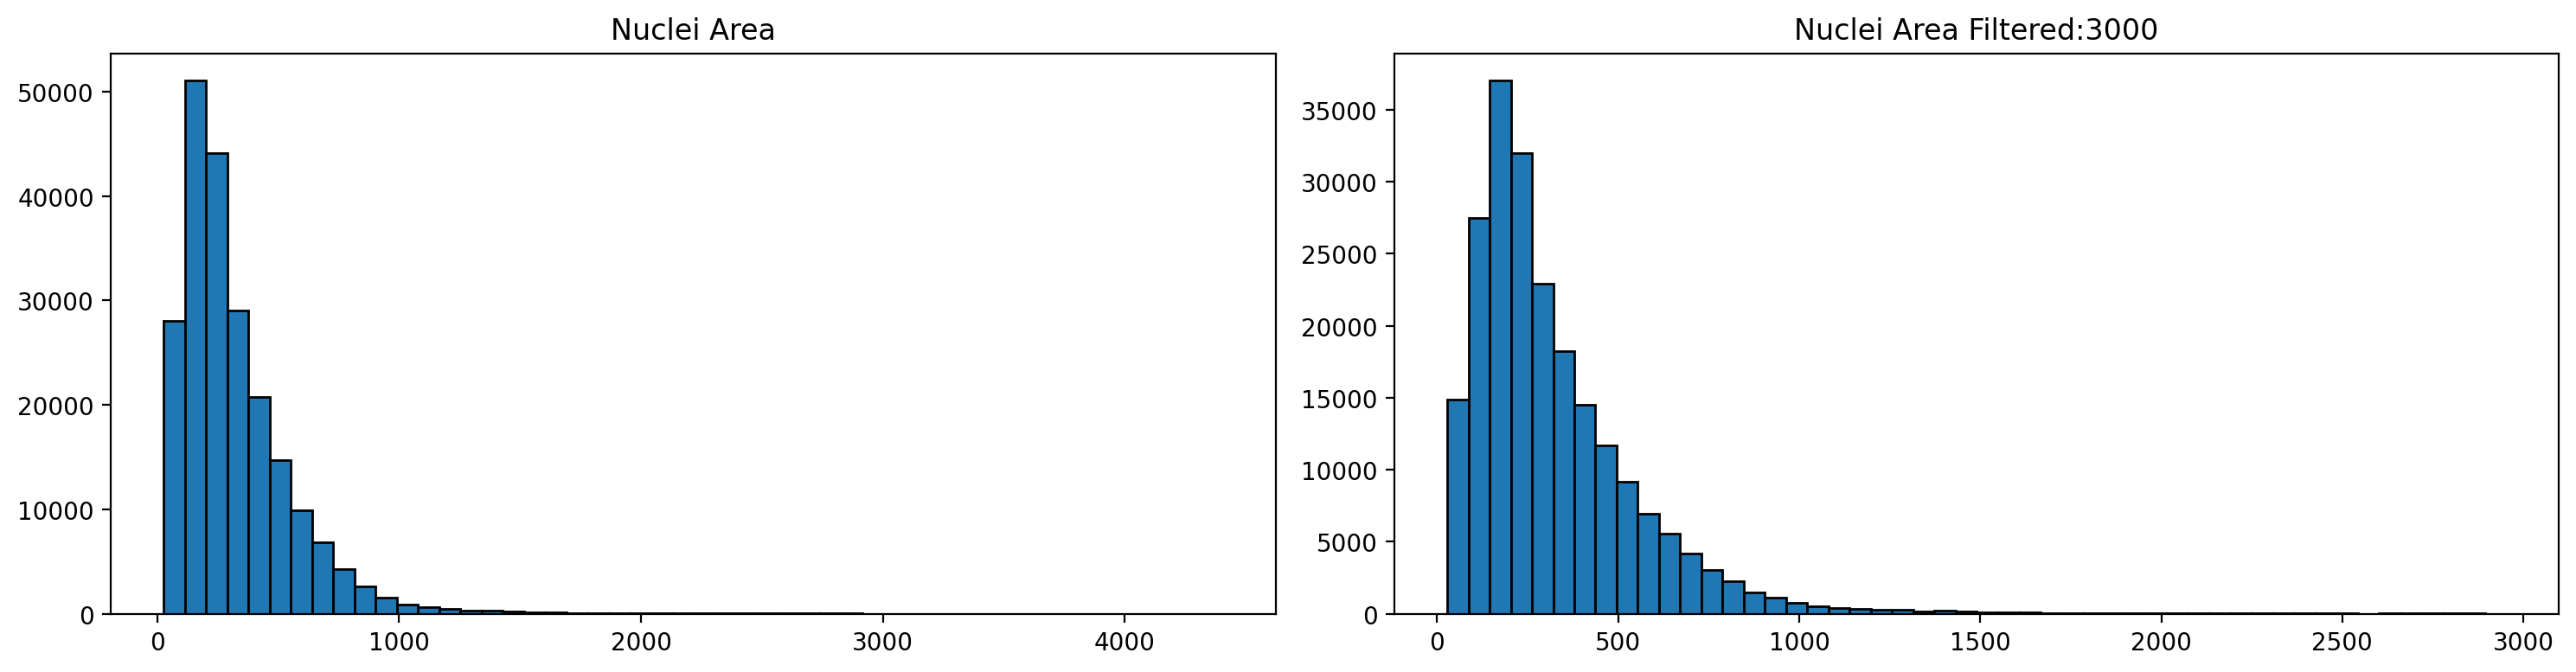

In [141]:
import sys
sys.path.append('../src/utils')
import os

import importlib
import image_plot_utils

# Reload the module
importlib.reload(image_plot_utils)

# Now try importing the function again
from image_plot_utils import plot_nuclei_area

# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=gdf,area_cut_off=3000)

In [142]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata[mask_area, :]

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.


In [143]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [144]:
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")

1979648850.py (1): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [145]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


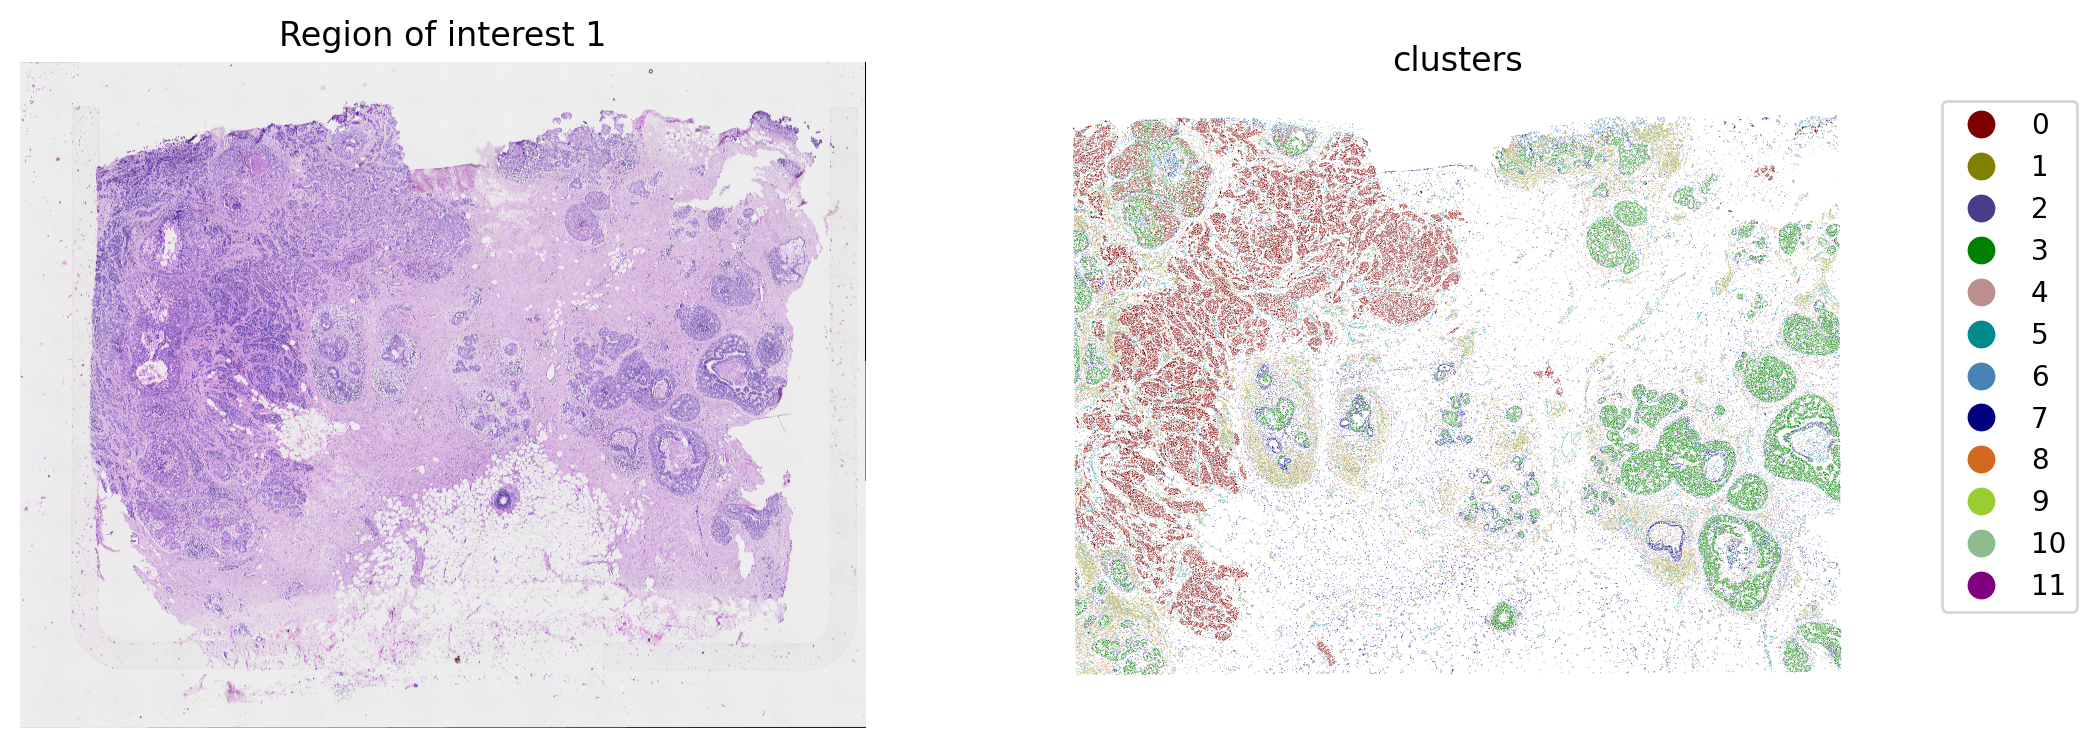

In [146]:
from image_plot_utils import plot_clusters_and_save_image
importlib.reload(image_plot_utils)
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [147]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

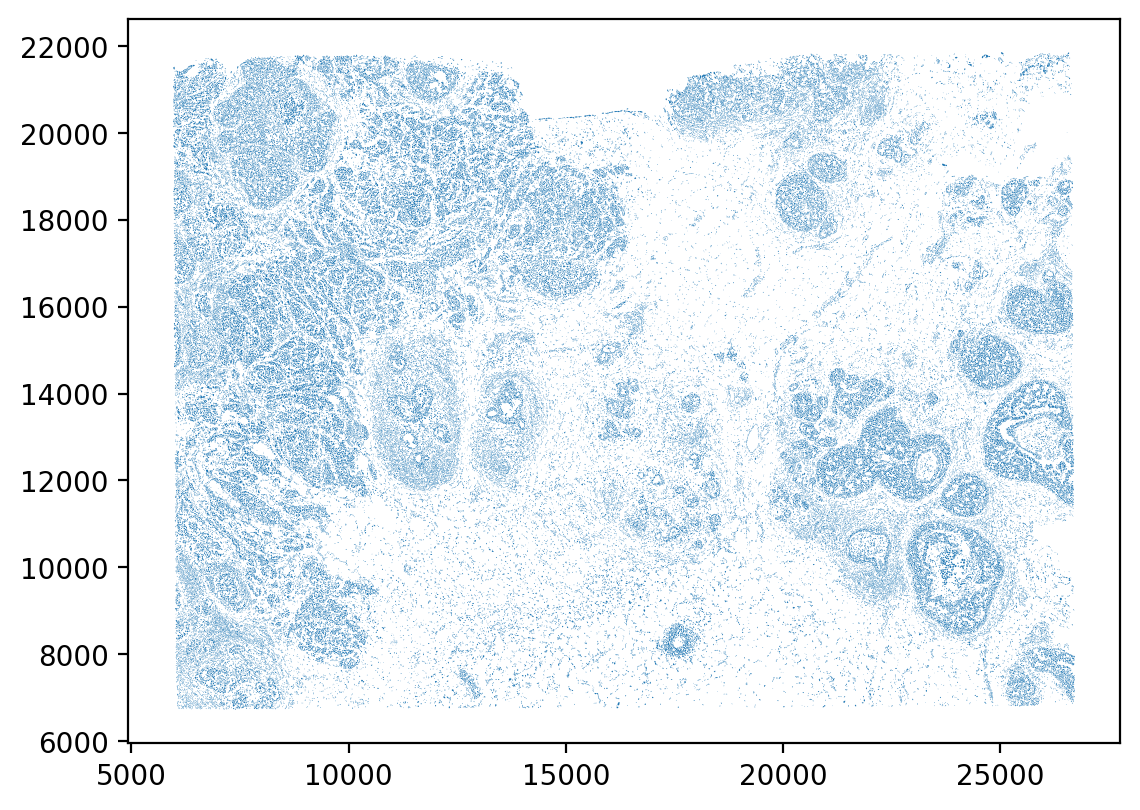

In [148]:
merged_gdf.plot()

In [149]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [150]:
merged_gdf_no_clusters.to_file("../data/xenium/outs/clusters/data_cells_NUCLEI_merged_cosine.geojson", driver='GeoJSON')

In [151]:
count_area_filtered_adata.write("../data/xenium/outs/clusters/count_area_filtered_adata_NUCLEI.h5ad")

# Save cluster assignments
#count_area_filtered_adata.obs[['clusters']].to_csv("../data/xenium/outs/clusters/cluster_assignments_voronoi_leiden.csv")

# Save GeoDataFrame
gdf.to_file("../data/xenium/outs/clusters/data_cells_v_NUCLEI.geojson", driver='GeoJSON')

In [152]:
merged_gdf_no_clusters

id                                           geometry   
6224      ID_6225  POLYGON ((7147.756 6836.000, 7147.470 6839.077...  \
6231      ID_6232  POLYGON ((6280.575 6964.000, 6280.311 6965.653...   
6234      ID_6235  POLYGON ((7205.946 6740.000, 7205.587 6741.907...   
6248      ID_6249  POLYGON ((6448.833 7252.000, 6448.276 7253.646...   
6252      ID_6253  POLYGON ((6924.299 7188.000, 6923.439 7190.275...   
...           ...                                                ...   
215214  ID_215215  POLYGON ((24364.991 21268.000, 24365.422 21269...   
215215  ID_215216  POLYGON ((25931.394 21776.000, 25931.607 21776...   
215217  ID_215218  POLYGON ((26654.858 21128.000, 26654.669 21128...   
215218  ID_215219  POLYGON ((25631.472 21608.000, 25631.918 21608...   
215220  ID_215221  POLYGON ((24879.726 21156.000, 24880.376 21156...   

              area  
6224    989.890053  
6231    372.125690  
6234    269.271466  
6248    288.273555  
6252    527.311285  
...            ...  
215214   81.387987  
215215  152.561310  
215217  155.985648  
215218   96.433117  
215220   98.787533  

[147341 rows x 3 columns]

<Axes: >

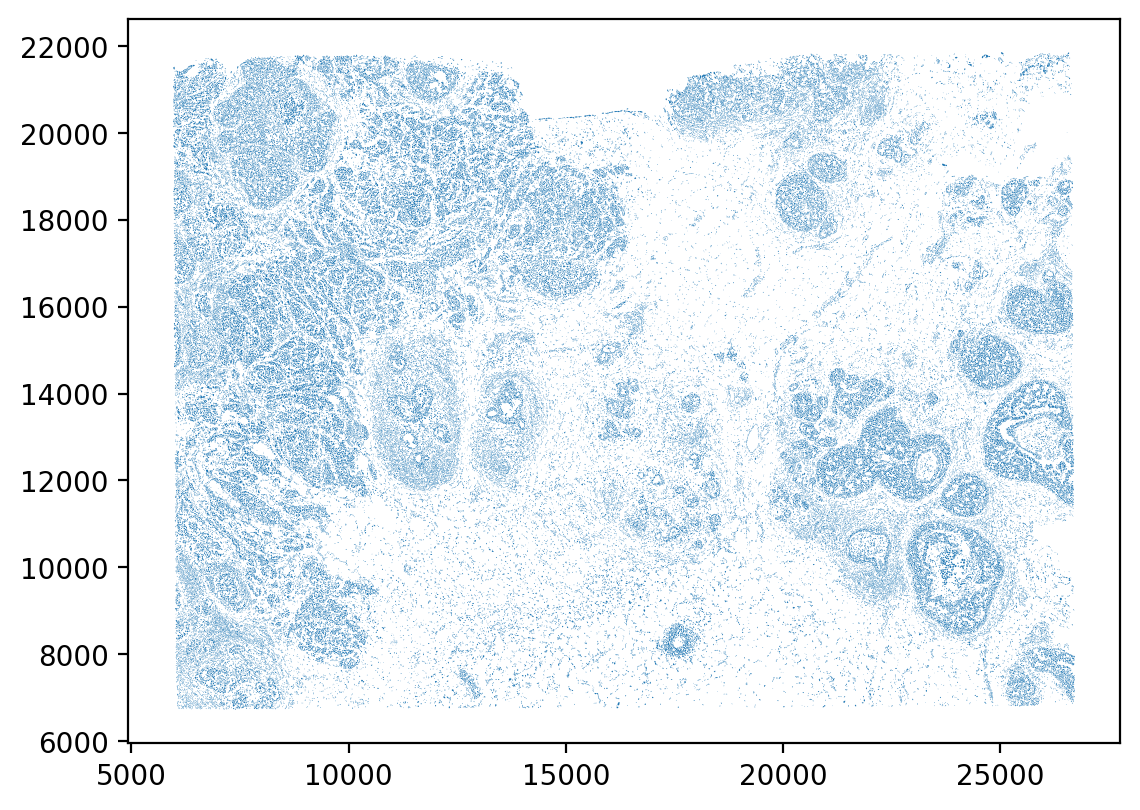

In [153]:
merged_gdf_no_clusters.plot()

In [154]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [155]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [156]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [157]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [158]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [159]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

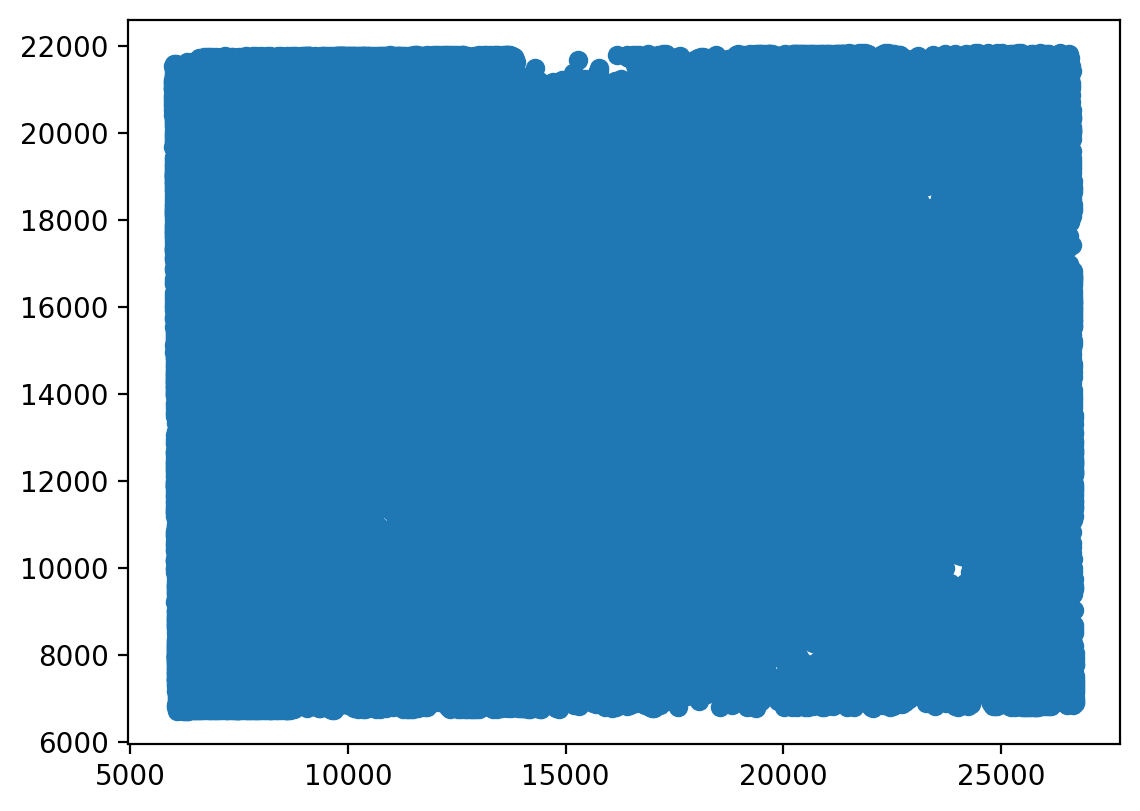

In [67]:
cells_gdf.plot()

In [71]:
merged_gdf_no_clusters

geometry         id   
6202    POLYGON ((7110.770 6825.238, 7124.374 6854.249...    ID_6203  \
6209    POLYGON ((6279.099 6982.299, 6281.607 6953.524...    ID_6210   
6212    POLYGON ((7193.251 6729.451, 7208.089 6732.524...    ID_6213   
6226    POLYGON ((6454.599 7248.218, 6443.083 7263.338...    ID_6227   
6230    POLYGON ((6907.168 7168.644, 6922.874 7168.744...    ID_6231   
...                                                   ...        ...   
215188  POLYGON ((24366.226 21234.299, 24332.589 21219...  ID_215189   
215189  POLYGON ((25935.394 21766.393, 25909.894 21765...  ID_215190   
215191  POLYGON ((26626.521 21099.852, 26611.965 21188...  ID_215192   
215192  POLYGON ((25655.911 21595.849, 25644.229 21622...  ID_215193   
215194  POLYGON ((24867.454 21126.586, 24805.642 21121...  ID_215195   

               area  
6202    1381.070529  
6209    1063.208957  
6212     532.757244  
6226     679.964088  
6230     905.575888  
...             ...  
215188  1704.299889  
215189   581.398304  
215191  2774.254191  
215192  1571.738396  
215194  2053.502814  

[132054 rows x 3 columns]

In [72]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

In [160]:
# Perform spatial join
#joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

In [161]:
joined = gpd.sjoin(cells_gdf, gdf, how='left', predicate='within')

In [162]:
joined

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  index_right   
0                 20873.427800  POINT (8297.872 20873.428)     203638.0  \
1                 20868.090296  POINT (8240.416 20868.090)          NaN   
2                 20858.192164  POINT (8302.087 20858.192)     203638.0   
3                 20850.967862  POINT (8234.692 20850.968)          NaN   
4                 20856.720876  POINT (8281.734 20856.721)     203638.0   
...                        ...                         ...          ...   
167775             7803.121686  POINT (26520.668 7803.122)          NaN   
167776             7812.837128  POINT (26598.255 7812.837)          NaN   
167777             7791.621519  POINT (26561.075 7791.622)          NaN   
167778             7765.396076  POINT (26582.026 7765.396)          NaN   
167779             7780.706674  POINT (26613.936 7780.707)      52547.0   

               id        area  
0       ID_203639  691.041289  
1             NaN         NaN  
2       ID_203639  691.041289  
3             NaN         NaN  
4       ID_203639  691.041289  
...           ...         ...  
167775        NaN         NaN  
167776        NaN         NaN  
167777        NaN         NaN  
167778        NaN         NaN  
167779   ID_52548  761.042851  

[167787 rows x 15 columns]

In [164]:
filtered_joined.to_file("../data/xenium/improved_outs/joined.geojson", driver='GeoJSON')

In [38]:
import geopandas as gpd
filtered_joined = gpd.read_file('../data/xenium/improved_outs/joined.geojson')

In [7]:
filtered_joined[filtered_joined['cell_id']==133665.0]

id  index_right   cell_id   x_centroid   y_centroid   
68304  ID_100036     133664.0  133665.0  5327.231396  3768.727344  \

       transcript_counts  control_probe_counts  control_codeword_counts   
68304               31.0                   0.0                      0.0  \

       total_counts  cell_area  nucleus_area  x_location_transformed   
68304          31.0  40.279375     18.649531            20654.454265  \

       y_location_transformed   
68304            11473.694848  \

                                                geometry  
68304  POLYGON ((20645.46313 11484.90644, 20658.47221...

In [163]:
filtered_joined = joined[~joined['index_right'].isna()]

In [39]:
filtered_joined

id  index_right   cell_id   x_centroid   y_centroid   
0         ID_6203      42284.0   42285.0   399.355255  5437.458716  \
1         ID_6210      42966.0   42967.0    82.964026  5382.626245   
2         ID_6227      43061.0   43062.0   145.100730  5281.886304   
3         ID_6231      42582.0   42583.0   318.665202  5303.403174   
4         ID_6243      43041.0   43042.0    64.706159  5305.564697   
...           ...          ...       ...          ...          ...   
167775  ID_215151     150706.0  150707.0  6780.770825   316.917836   
167776  ID_215162      12176.0   12177.0  6817.952515     8.849210   
167777  ID_215171      12242.0   12243.0  7417.128223    26.647450   
167778  ID_215171      12241.0   12242.0  7423.180322     9.744251   
167779  ID_215193     151019.0  151020.0  7148.162988    85.906860   

        transcript_counts  control_probe_counts  control_codeword_counts   
0                   592.0                   0.0                      0.0  \
1                   173.0                   0.0                      0.0   
2                   108.0                   0.0                      0.0   
3                   252.0                   1.0                      0.0   
4                    97.0                   0.0                      0.0   
...                   ...                   ...                      ...   
167775              346.0                   0.0                      0.0   
167776               17.0                   0.0                      0.0   
167777              269.0                   0.0                      0.0   
167778               68.0                   0.0                      0.0   
167779               88.0                   0.0                      0.0   

        total_counts   cell_area  nucleus_area  x_location_transformed   
0              592.0  398.142656    147.525469             7135.520510  \
1              173.0  179.405781     55.813125             6265.376854   
2              108.0  110.632812     36.079844             6434.772936   
3              253.0  150.280000     75.320625             6911.997752   
4               97.0  108.962031     28.854844             6214.174281   
...              ...         ...           ...                     ...   
167775         346.0  500.376406     28.674219            24602.404125   
167776          17.0  520.425781     13.953281            24700.450230   
167777         269.0  409.522031      8.037812            26347.159620   
167778          68.0  633.813125      9.844062            26363.563802   
167779          88.0   77.126875     17.881875            25608.865307   

        y_location_transformed   
0                  6822.211526  \
1                  6968.648654   
2                  7246.303336   
3                  7189.501397   
4                  7180.161100   
...                        ...   
167775            20978.363664   
167776            21825.401338   
167777            21784.516984   
167778            21831.046215   
167779            21618.076830   

                                                 geometry  
0       POLYGON ((7110.76958 6825.23779, 7124.37383 68...  
1       POLYGON ((6279.09922 6982.29949, 6281.60677 69...  
2       POLYGON ((6454.59923 7248.21802, 6443.08310 72...  
3       POLYGON ((6907.16755 7168.64380, 6922.87443 71...  
4       POLYGON ((6197.15225 7191.23388, 6198.14466 71...  
...                                                   ...  
167775  POLYGON ((24644.67201 21027.91754, 24632.96144...  
167776  POLYGON ((24721.27345 21834.45736, 24626.16810...  
167777  POLYGON ((26325.46164 21748.07328, 26364.10917...  
167778  POLYGON ((26325.46164 21748.07328, 26364.10917...  
167779  POLYGON ((25655.91110 21595.84870, 25644.22933...  

[167780 rows x 14 columns]

In [165]:
unique_ids = filtered_joined['id'].unique()

In [166]:
len(unique_ids)

89815

In [167]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
(0, 1429)    sample1   5977.914968  20190.082661   5987.326733  20199.494426   
...              ...           ...           ...           ...           ...   
(2201, 120)  sample1  26693.209086   7870.082661  26702.620851   7879.494426   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1425)     5982.620851  20157.141485                  1   
(0, 1429)     5982.620851  20194.788543                  1   
...                   ...           ...                ...   
(2201, 120)  26697.914968   7874.788543                  5   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1425)                   0.693147             1            0.693147   
(0, 1429)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 120)                 1.791759             5            1.791759   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
(0, 1429)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 120)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [168]:

indices_to_keep = filtered_adata.obs['id'].isin(unique_ids)

# Filter the entire AnnData object
filtered_adata2 = filtered_adata[indices_to_keep].copy()

In [169]:
filtered_adata2.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1431)    sample1   5977.914968  20208.906190   5987.326733  20218.317955   
(0, 1463)    sample1   5977.914968  20510.082661   5987.326733  20519.494426   
...              ...           ...           ...           ...           ...   
(2201, 120)  sample1  26693.209086   7870.082661  26702.620851   7879.494426   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1431)     5982.620851  20213.612073                  1   
(0, 1463)     5982.620851  20514.788543                  4   
...                   ...           ...                ...   
(2201, 120)  26697.914968   7874.788543                  5   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1431)                   0.693147             1            0.693147   
(0, 1463)                   1.609438             4            1.609438   
...                              ...           ...                 ...   
(2201, 120)                 1.791759             5            1.791759   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1431)                         100.0                        100.0   
(0, 1463)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 120)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [170]:
filtered_adata2

AnnData object with n_obs × n_vars = 379398 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'index', 'geometry', 'id', 'is_within_polygon', 'is_not_in_an_polygon_overlap'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [171]:
groupby_object = filtered_adata2.obs.groupby(['id'], observed=True)

In [172]:
import numpy as np

def get_min_max_ids_numpy(id_dict):
    # Convert all arrays to a single flat array
    all_ids = np.concatenate(list(id_dict.values()))
    
    # Find the min and max
    min_id = np.min(all_ids)
    max_id = np.max(all_ids)
    
    return min_id, max_id


min_id, max_id = get_min_max_ids_numpy(groupby_object.indices)
print("Min ID:", min_id)
print("Max ID:", max_id)


Min ID: 0
Max ID: 379397


In [173]:
filtered_adata2.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1431)    sample1   5977.914968  20208.906190   5987.326733  20218.317955   
(0, 1463)    sample1   5977.914968  20510.082661   5987.326733  20519.494426   
...              ...           ...           ...           ...           ...   
(2201, 120)  sample1  26693.209086   7870.082661  26702.620851   7879.494426   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1431)     5982.620851  20213.612073                  1   
(0, 1463)     5982.620851  20514.788543                  4   
...                   ...           ...                ...   
(2201, 120)  26697.914968   7874.788543                  5   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1431)                   0.693147             1            0.693147   
(0, 1463)                   1.609438             4            1.609438   
...                              ...           ...                 ...   
(2201, 120)                 1.791759             5            1.791759   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1431)                         100.0                        100.0   
(0, 1463)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 120)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [174]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata2.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata2 = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata2.var)

%store grouped_filtered_adata2


Stored 'grouped_filtered_adata2' (AnnData)


In [175]:
grouped_filtered_adata2

AnnData object with n_obs × n_vars = 88436 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [176]:
grouped_filtered_adata2.write("../data/xenium/grouped_filtered_voronoi_adata_second_attempt.h5ad")

geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


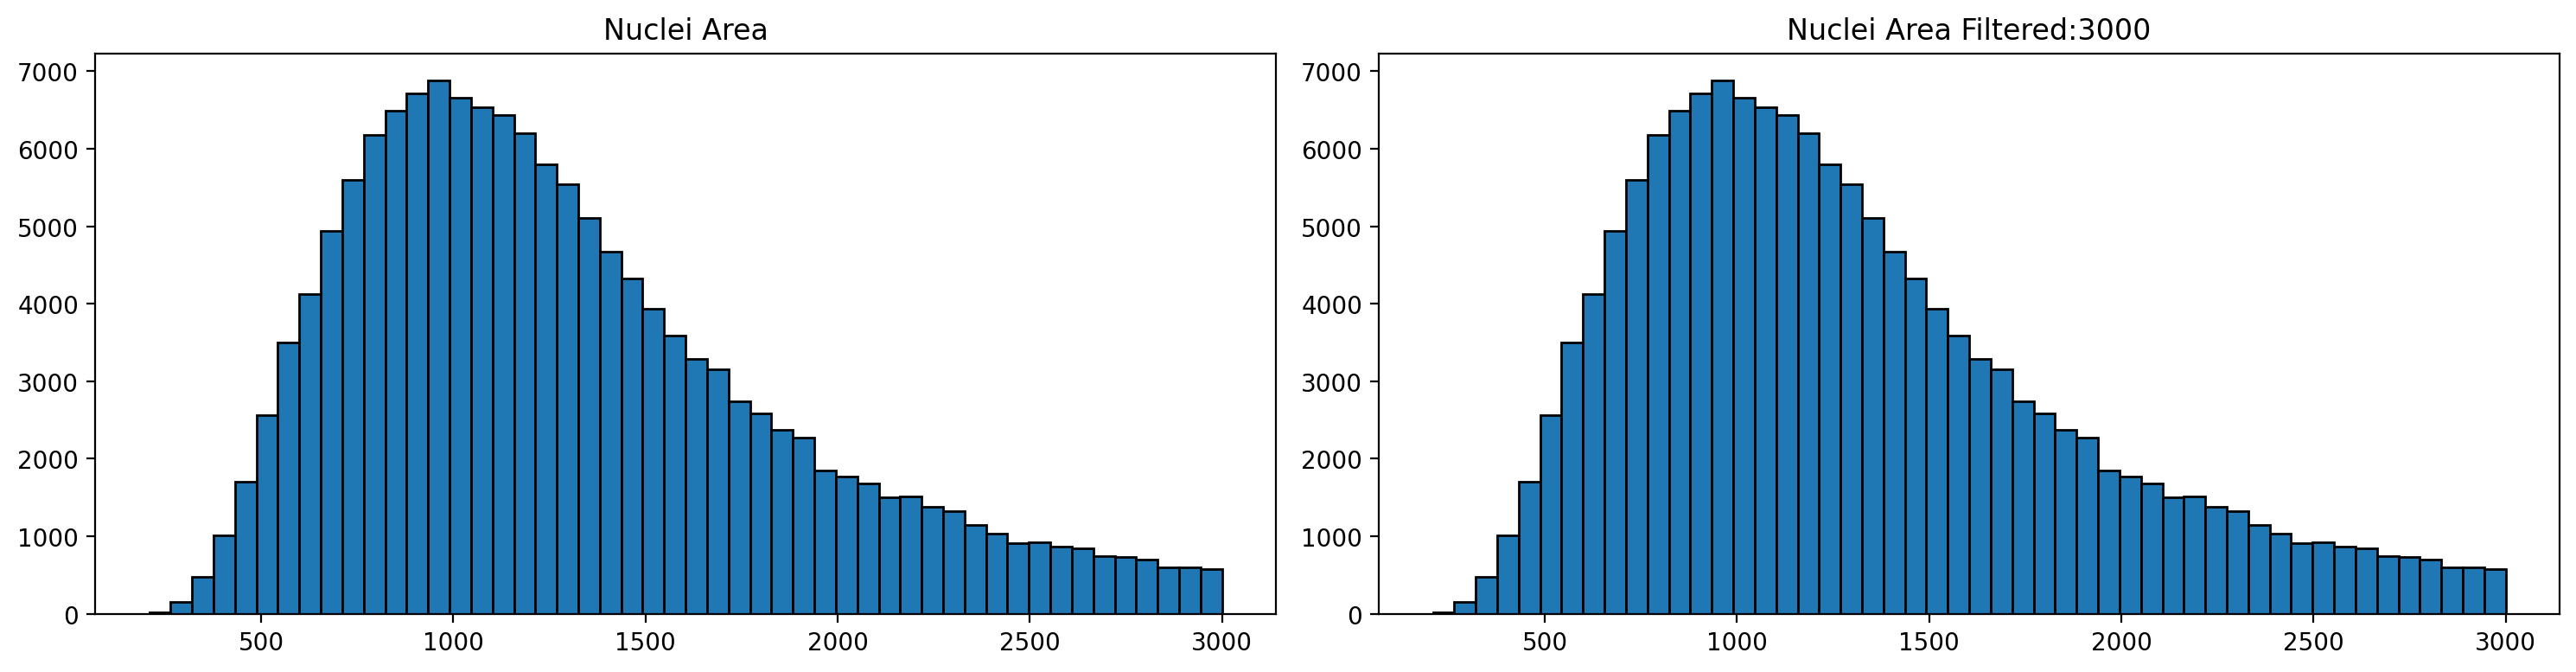

In [108]:
import sys
sys.path.append('../src/utils')
import os

import importlib
import image_plot_utils

# Reload the module
importlib.reload(image_plot_utils)

# Now try importing the function again
from image_plot_utils import plot_nuclei_area

# Store the area of each nucleus in the GeoDataframe
filtered_joined['area'] = filtered_joined['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata2, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=filtered_joined,area_cut_off=3000)

In [109]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata2.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata2 = grouped_filtered_adata2[mask_area, :]

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata2, inplace=True)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.


In [110]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata2, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata2)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata2, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata2)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata2)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
sc.tl.leiden(count_area_filtered_adata2, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


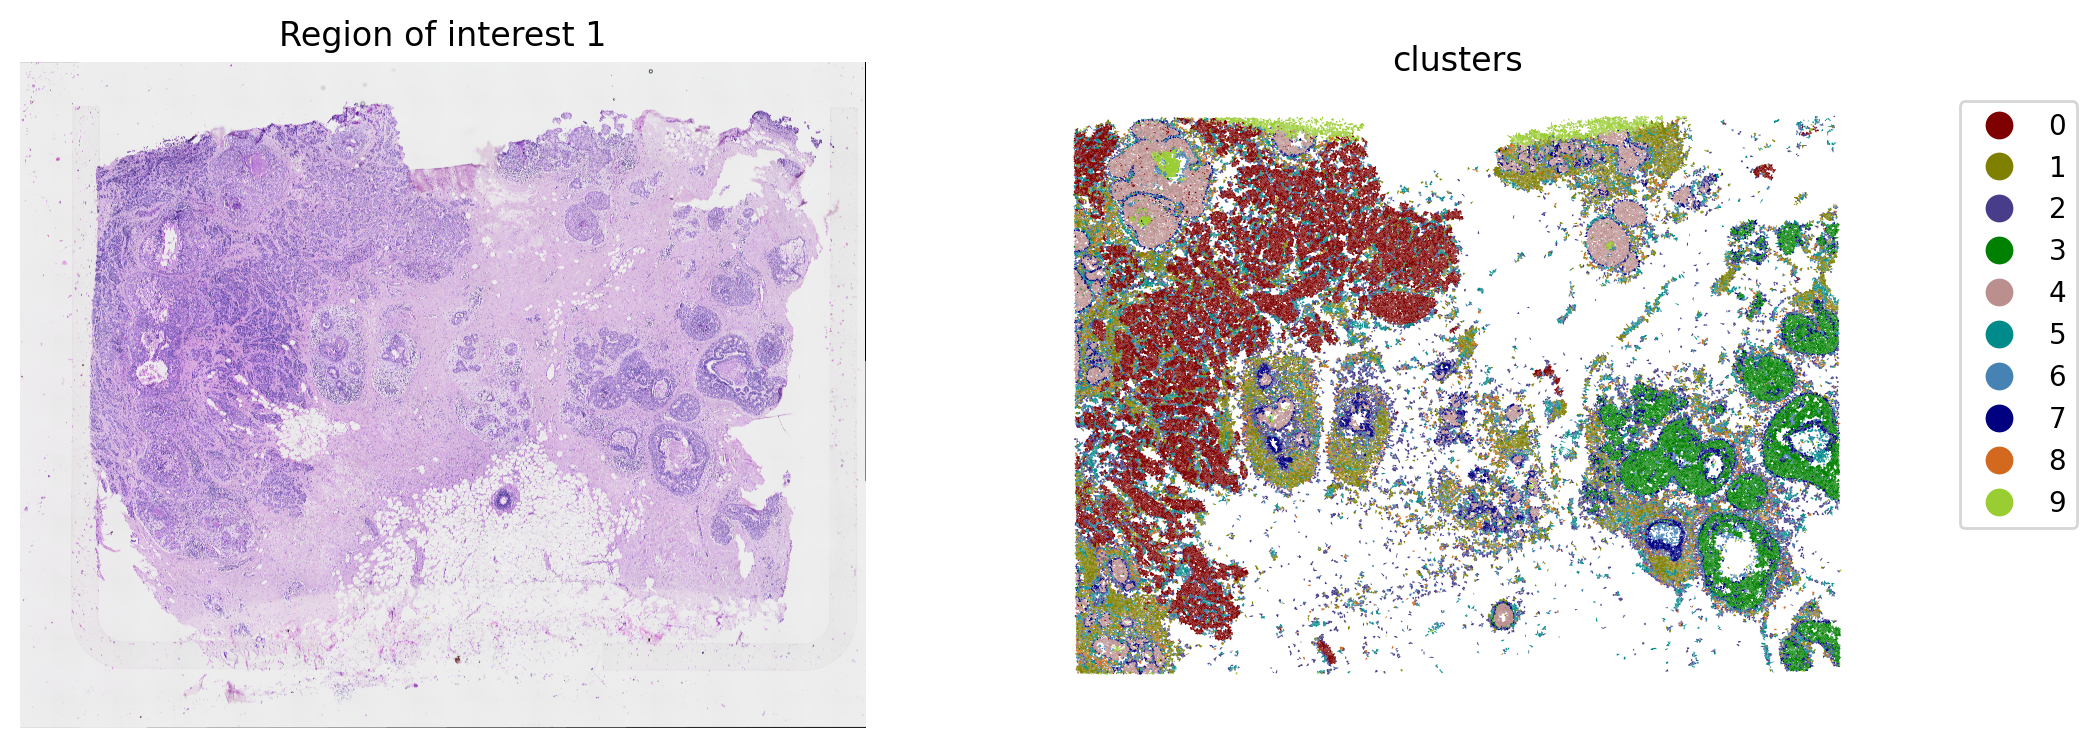

In [111]:
from image_plot_utils import plot_clusters_and_save_image
importlib.reload(image_plot_utils)
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=filtered_joined, img=img, adata=count_area_filtered_adata2, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [112]:
filtered_joined.to_file("../data/xenium/outs/clusters/data_cells_voronoi2.geojson", driver='GeoJSON')